기존 코드는 텐서플로우 버전 1.xx에서 작동하는 코드로, 버전 2.xx에서는 작동에 어려움이 있었기에, <br>
동일한 알고리즘을 이용하여 코드 다시 구성


In [32]:
# 필요한 라이브러리
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [16]:
#-------------------------------------------------
# 데이터 불러오기
#-------------------------------------------------
raw_data = open('input.txt', 'r').read()  # input.txt 예제 데이터
# 계산 시간 때문에 일부만 사용
raw_data = raw_data[:200000]
# 전체 문자 수
n_samples = len(raw_data)
# 고유한 문자
unique_chars = list(set(raw_data))
# 문자를 정수로 변환하는 딕셔너리
char_to_int = {ch: i for i, ch in enumerate(unique_chars)}
# 정수를 문자로 변환하는 딕셔너리
int_to_char = {i: ch for i, ch in enumerate(unique_chars)}
# 고유한 문자 수
n_unique_chars = len(unique_chars)

In [19]:
print(raw_data) # raw_data 확인

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [30]:
#-------------------------------------------
# 매개변수 설정
#-------------------------------------------
batch_size = 100
seq_len = 50  # 한 번에 입력되는 서열 길이
hidden_size = 32  # 은닉층 노드 수
learning_rate = 0.05
grad_clip = 5  # Gradient Clipping에 사용할 임곗값
nepochs = 40  # 반복 수 -> 50으로 했을 경우 컴퓨터 사양문제로 실행이 중간에 멈춰서 40으로 변경

In [21]:
# 배치 개수
num_batches = int(len(raw_data) / (batch_size * seq_len))
# 데이터 - (배치 크기*배치 개수)
data = raw_data[:num_batches * batch_size * seq_len]
# 데이터를 정수로 변환
data = np.array([char_to_int[ch] for ch in data])
# 입력과 목표 데이터 설정
xdata = data
ydata = np.copy(data)
ydata[:-1] = xdata[1:]
ydata[-1] = xdata[0]

# 배치 개수*배치 크기*서열 길이 = (?, 100, 32)
x_batches = np.split(xdata.reshape(batch_size, -1), num_batches, 1)
x_batches = np.asarray(x_batches)
y_batches = np.split(ydata.reshape(batch_size, -1), num_batches, 1)
y_batches = np.asarray(y_batches)

In [22]:
# 모델 구성: 은닉층이 3개인 LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_unique_chars, output_dim=hidden_size),
    tf.keras.layers.LSTM(hidden_size, return_sequences=True, stateful=True, dropout=0.2), # 드롭아웃 사용
    tf.keras.layers.LSTM(hidden_size, return_sequences=True, stateful=True),
    tf.keras.layers.LSTM(hidden_size, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_unique_chars)
])

In [23]:
# 손실 함수 및 최적화
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss) # 옵티마이저: adam

In [24]:
#------------------------------------------------
# 텐서플로 그래프 생성 및 학습 
#------------------------------------------------
losses = []
for epoch in range(nepochs):
    bat_loss = []
    for j in range(len(x_batches)):
        x_batch = x_batches[j]
        y_batch = y_batches[j]
        loss_value = model.train_on_batch(x_batch, y_batch)
        bat_loss.append(loss_value)
    mean_bat_loss = np.mean(bat_loss)
    if epoch % 1 == 0:
        print('epoch={}, loss={:.4f}'.format(epoch, mean_bat_loss))
    losses.append(mean_bat_loss)

epoch=0, loss=3.9650
epoch=1, loss=3.6225
epoch=2, loss=3.4956
epoch=3, loss=3.4403
epoch=4, loss=3.4088
epoch=5, loss=3.3850
epoch=6, loss=3.3605
epoch=7, loss=3.3341
epoch=8, loss=3.3065
epoch=9, loss=3.2785
epoch=10, loss=3.2490
epoch=11, loss=3.2190
epoch=12, loss=3.1896
epoch=13, loss=3.1617
epoch=14, loss=3.1355
epoch=15, loss=3.1111
epoch=16, loss=3.0881
epoch=17, loss=3.0665
epoch=18, loss=3.0459
epoch=19, loss=3.0264
epoch=20, loss=3.0077
epoch=21, loss=2.9899
epoch=22, loss=2.9728
epoch=23, loss=2.9562
epoch=24, loss=2.9397
epoch=25, loss=2.9233
epoch=26, loss=2.9069
epoch=27, loss=2.8907
epoch=28, loss=2.8749
epoch=29, loss=2.8595
epoch=30, loss=2.8445
epoch=31, loss=2.8300
epoch=32, loss=2.8160
epoch=33, loss=2.8024
epoch=34, loss=2.7893
epoch=35, loss=2.7765
epoch=36, loss=2.7642
epoch=37, loss=2.7521
epoch=38, loss=2.7403
epoch=39, loss=2.7288


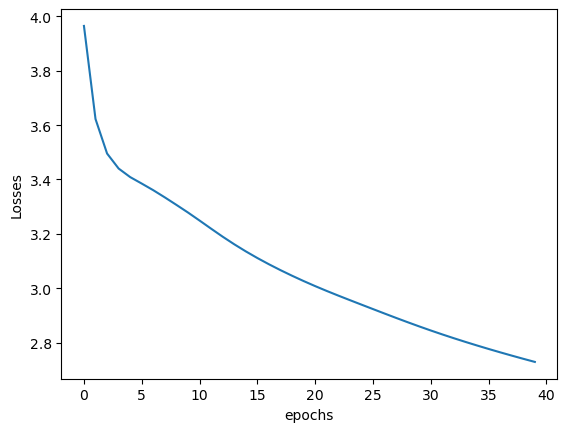

In [26]:
# 훈련과정의 loss 그림
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.show()

In [27]:
import numpy as np
# 생성할 문장의 길이
generated_text_len = 200
# 시작 문자를 't'로 지정.
generated_text = 't'

for n in range(generated_text_len):
    
    if len(generated_text) > seq_len:
        gen_text_input = generated_text[1:]
    else:   
        gen_text_input = generated_text
        
    gen_text_input = np.array([char_to_int.get(x, 0) for x in generated_text]).reshape(1, -1)
    
    probs_result = model.predict(gen_text_input)
    p = np.squeeze(probs_result)[-1] 
    # 다음 문자를 예측할때 확률을 이용한 random sampling을 사용
    sample = int(np.searchsorted(np.cumsum(p), np.random.rand(1) * np.sum(p)))  
    # int_to_char 딕셔너리에서 sample에 해당하는 값이 없을 때 공백표기로 오류 제어
    pred = int_to_char.get(sample, ' ') 
    # 생성된 문자열에 현재 스텝에서 예측한 문자 추가. 
    generated_text += pred
   
print(generated_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/s

모델이 생성한 텍스트의 대부분이 의미 없는 문자열로 보여진다. 예상한 것보다 훨씬 낮은 품질의 텍스트가 생성되었다. <br>
모델이 학습을 제대로 수행하지 못하는 주요 원인으로는 하이퍼파라미터 설정, 모델 구조, 그리고 옵티마이저 및 손실 함수 선택 등이 있다. <br>
데이터의 양은 충분하다고 판단되어 이를 고려하지 않았으며, 손실이 발생한 것 을 보아 과적합의 가능성도 적다고 생각한다. <br><br>
우선, 하이퍼파라미터 값이 적절하지 않은 것으로 추측한다. <br>
원래는 에폭 수를 50으로 설정하였으나, 개인 컴퓨터 문제로 인해 40으로 변경하였다. 이로 인해 학습에 영향을 줄 수 있다. <br>
또한, 모델은 세 개의 LSTM 층으로만 구성되어 있어서 데이터의 복잡한 패턴을 충분히 학습하지 못할 수 있다고 생각한다. <br>
마지막으로, 현재 사용된 옵티마이저와 손실 함수가 모델의 학습에 영향을 미칠 가능성도 고려될 수 있다. <br>
때문에 위의 문제점들을 고려하여 모델을 개선한다면 모델이 적합한 텍스트를 생성하는데 도움을 줄 수 있다고 생각한다.